In [6]:
!pip install pydub

In [7]:
import os
from pydub import AudioSegment
from sklearn.model_selection import train_test_split

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
data_dir = '/content/drive/MyDrive/yazlab/divide'

In [10]:
classes = ['azerice', 'kazakca', 'kirgizca', 'ozbekce', 'turkce']

In [ ]:
# # Drive klasör erişim kontrolleri için - Bu kısım Drive'daki dosyaların önbelleğe alınıp kolay erişilebilmesi için gereklidir.
# for class_name in classes:
#     class_output_dir = os.path.join(output_dir, class_name)
#     try:
#         file_list = os.listdir(class_output_dir)
#         print(f"Directory '{class_output_dir}' contains {len(file_list)} files.")
#     except OSError as e:
#         print(f"Error accessing directory {class_output_dir}: {e}")

In [ ]:
# # Her bir sınıf için ses dosyalarını işleme
# for label, class_name in enumerate(classes):
#     class_dir = os.path.join(data_dir, class_name)
#     class_output_dir = os.path.join(output_dir, class_name)
#     os.makedirs(class_output_dir, exist_ok=True)

#     for filename in os.listdir(class_dir):
#         if filename.endswith('.mp3 adlı dosyanın kopyası'):
#             file_path = os.path.join(class_dir, filename)
#             audio = AudioSegment.from_file(file_path, format='mp3')

#             # 10 saniyelik segmentlere ayırma
#             duration = 10 * 1000  # 10 saniye milisaniye cinsinden
#             for i in range(0, len(audio), duration):
#                 segment = audio[i:i + duration]
#                 if len(segment) < duration:
#                     segment = segment + AudioSegment.silent(duration - len(segment))  # 10 saniyeye tamamla
#                 segment_filename = f'{os.path.splitext(filename)[0]}_{i // duration}.mp3'
#                 segment_path = os.path.join(class_output_dir, segment_filename)
#                 segment.export(segment_path, format='mp3')

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from pydub import AudioSegment
import io
import librosa

In [12]:
import numpy as np
from tqdm import tqdm

# Segmentleri ve etiketleri yüklemek için listeler
segments = []
labels = []

for label, class_name in enumerate(classes):
    class_data_dir = os.path.join(data_dir, class_name)

    # İlerleme göstergesi için tqdm kullanımı
    files = [f for f in os.listdir(class_data_dir) if f.endswith('.wav')]
    for filename in tqdm(files, desc=f"Loading {class_name} segments"):
        file_path = os.path.join(class_data_dir, filename)

        try:
            # `librosa` ile ses dosyasını yükleyin
            audio, sr = librosa.load(file_path, sr=16000)
            segment_array = np.array(audio)

            # Check if the segment array has the same shape as the others
            if segments and segment_array.shape != segments[0].shape:
                # Normalize and fix the length of the segment array
                segment_array = librosa.util.normalize(segment_array)
                segment_array = librosa.util.fix_length(segment_array, size=segments[0].shape[0])

            segments.append(segment_array)
            labels.append(label)

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

# Sonuçları kontrol etme
print(f"Loaded {len(segments)} segments with corresponding labels.")

Loading turkce segments: 100%|██████████| 3850/3850 [02:00<00:00, 32.00it/s]

Loaded 20534 segments with corresponding labels.


In [13]:
np.savez("/content/drive/MyDrive/yazlab/processed_segments.npz", segments=segments, labels=labels)
print("Saved segments and labels")

Saved segments and labels


In [14]:
# Segmentleri ve etiketleri numpy dizilerine dönüştürme
segments_np = np.array(segments)
labels_np = np.array(labels)

In [15]:
# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(segments_np, labels_np, test_size=0.2, random_state=42)

In [16]:
print(f'Toplam dosya sayısı: {len(segments_np)}')
print(f'Eğitim seti dosya sayısı: {len(X_train)}')
print(f'Test seti dosya sayısı: {len(X_test)}')

Toplam dosya sayısı: 20534
Eğitim seti dosya sayısı: 16427
Test seti dosya sayısı: 4107


In [17]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset

In [18]:
# ASTFeatureExtractor'ı başlatma
feature_extractor = Wav2Vec2FeatureExtractor("anton-l/wav2vec2-random-tiny-classifier", sampling_rate = 16000)

In [19]:
# Ses verilerini özelliklere dönüştürme
X_train_features = feature_extractor(X_train, sampling_rate=16000, return_tensors="pt")
X_test_features = feature_extractor(X_test, sampling_rate=16000, return_tensors="pt")

In [20]:
# Numpy verilerini PyTorch tensörlerine dönüştürme ve DataLoader oluşturma
train_dataset = TensorDataset(X_train_features['input_values'], torch.tensor(y_train))
test_dataset = TensorDataset(X_test_features['input_values'], torch.tensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [21]:
# ASTForAudioClassification modelini başlatma
model = Wav2Vec2ForSequenceClassification.from_pretrained("anton-l/wav2vec2-random-tiny-classifier", num_labels=len(classes), ignore_mismatched_sizes=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at

In [22]:
# Optimizasyon fonksiyonunu tanımlama
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Kayıp fonksiyonu tanımlama
loss_fn = torch.nn.CrossEntropyLoss()

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 32, kernel_size=(2,), stride=(320,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(32, 32, eps=1e-05, affine=True)
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=32, out_features=32, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Wav2Vec2Encoder(
      (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
        (conv): ParametrizedConv1d(
          32, 32, kernel_size=(8,), stride=(1,), padding=(4,), groups=2
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
    

In [25]:
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for batch in train_loader:
        input_values, labels = batch
        input_values = input_values.to(device)
        labels = labels.to(device)

        outputs = model(input_values.to(device))
        logits = outputs.logits.to(device)
        loss = loss_fn(logits, labels)

        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(train_loader), correct_predictions.double() / len(train_loader.dataset)

In [26]:
all_preds = []
all_labels = []

def eval_model(model, test_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in test_loader:
            input_values, labels = batch
            input_values = input_values.to(device)
            labels = labels.to(device)

            outputs = model(input_values.to(device))
            logits = outputs.logits.to(device)
            loss = loss_fn(logits, labels)

            total_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(test_loader), correct_predictions.double() / len(test_loader.dataset), all_preds, all_labels

In [27]:
num_epochs = 20
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [28]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    test_loss, test_acc, test_preds, test_labels = eval_model(model, test_loader, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Train Loss: {train_loss}, Train Accuracy: {train_acc}')
    print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

Epoch 1/20
Train Loss: 1.5776929468816072, Train Accuracy: 0.2711998538990686
Test Loss: 1.5469317524349644, Test Accuracy: 0.29851473094716335
Epoch 2/20
Train Loss: 1.5311712083472946, Train Accuracy: 0.3163085164667925
Test Loss: 1.5127794598790922, Test Accuracy: 0.32091551010469926
Epoch 3/20
Train Loss: 1.4647741028721633, Train Accuracy: 0.37414013514336153
Test Loss: 1.3888203388058258, Test Accuracy: 0.4190406622839055
Epoch 4/20
Train Loss: 1.3748531478521537, Train Accuracy: 0.415352772873927
Test Loss: 1.5922201264229265, Test Accuracy: 0.3296810323837351
Epoch 5/20
Train Loss: 1.2922777451698133, Train Accuracy: 0.45705241370913735
Test Loss: 1.3550202120602826, Test Accuracy: 0.4151448746043341
Epoch 6/20
Train Loss: 1.2330125133273897, Train Accuracy: 0.49077737870578925
Test Loss: 1.2158824458196469, Test Accuracy: 0.4823472120769418
Epoch 7/20
Train Loss: 1.1822622348178096, Train Accuracy: 0.5175016740731722
Test Loss: 1.1392927315912358, Test Accuracy: 0.535427319211

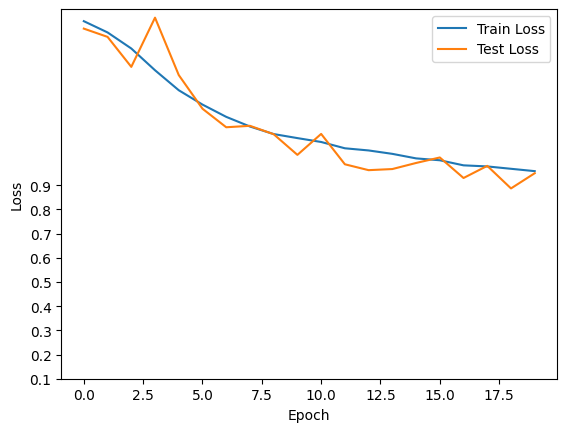

In [29]:
# Accuracy ve loss grafikleri
plt.figure()
plt.subplot(1, 1, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yticks([i/10 for i in range(1, 10)])
plt.legend()

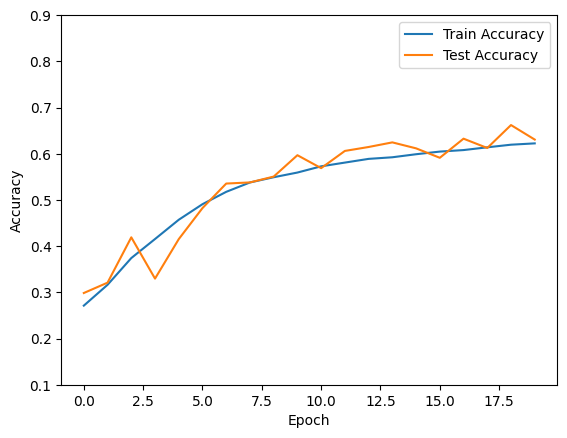

In [30]:
# plt.subplot(1, 2, 2)
# plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
# plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# Train accuracy verilerini CPU belleğine kopyala
train_accuracies_cpu = [acc.cpu().numpy() for acc in train_accuracies]
test_accuracies_cpu = [acc.cpu().numpy() for acc in test_accuracies]

# Grafik çizdirme işlemi
plt.figure()
plt.subplot(1, 1, 1)
plt.plot(range(num_epochs), train_accuracies_cpu, label='Train Accuracy')
plt.plot(range(num_epochs), test_accuracies_cpu, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yticks([i/10 for i in range(1, 10)])
plt.legend()

In [31]:
# Precision, Recall, F1-Score hesaplama
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Precision: 0.5387394897929708
Recall: 0.5306540271103339
F1-Score: 0.5326930307608702


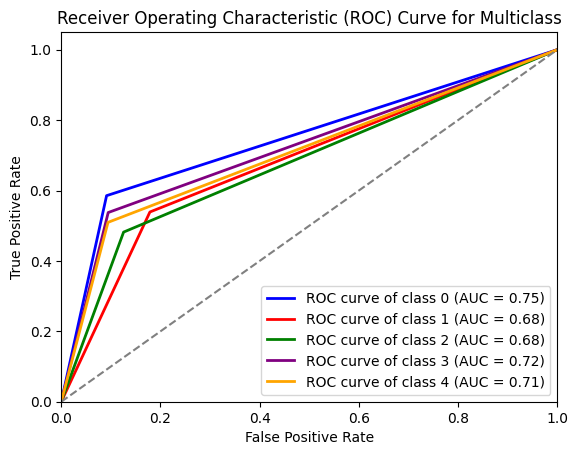

In [32]:
from sklearn.metrics import auc, roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import label_binarize

labels = np.array(all_labels)
preds = np.array(all_preds)

# Sınıfları ikili hale getirin
n_classes = len(np.unique(labels))
labels = label_binarize(labels, classes=[0, 1, 2, 3, 4])
preds = label_binarize(preds, classes=[0, 1, 2, 3, 4])

# Her sınıf için ROC ve AUC hesapla
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC eğrisini çizdir
plt.figure()
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc="lower right")
plt.show()

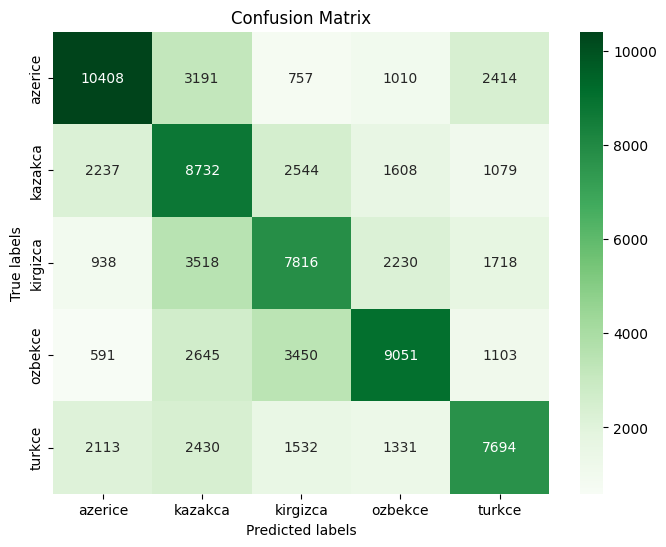

In [33]:
# Confusion matrix oluştur
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [34]:
from sklearn.metrics import classification_report
import pandas as pd

# Sınıfları ikili hale getirin
class_names = ['azerice', 'kazakca', 'kirgizca', 'ozbekce', 'turkce']

# Classification report oluştur
report = classification_report(labels, preds, target_names=class_names, output_dict=True)

# DataFrame'e dönüştür ve precision ve recall sütunlarını seç
df_report = pd.DataFrame(report).transpose()
df_precision_recall = df_report[['precision', 'recall']]

# Precision ve recall değerlerini tablo olarak yazdır
print(df_precision_recall)

              precision    recall
azerice        0.639037  0.585377
kazakca        0.425619  0.539012
kirgizca       0.485496  0.481874
ozbekce        0.594288  0.537470
turkce         0.549258  0.509536
micro avg      0.532031  0.532031
macro avg      0.538739  0.530654
weighted avg   0.540948  0.532031
samples avg    0.532031  0.532031


In [49]:
import torch

# Assuming 'model' is your trained PyTorch model
model_save_path_bin = '/content/drive/MyDrive/saved_models/random_tiny.pt'

# Save the entire model (not just the state dictionary)
torch.save(model, model_save_path_bin)

print(f"Model saved as binary to {model_save_path_bin}")

Model saved as binary to /content/drive/MyDrive/saved_models/random_tiny.pt


In [1]:
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
import librosa
import numpy as np

# Modelin Kaydedildiği Yol
model_save_path_bin = '/content/drive/MyDrive/saved_models/random_tiny.pt'

# Ses Dosyalarının Bulunduğu Yol (Tahmin Yapılacak Ses Dosyaları)
audio_file_paths = [
    '/content/drive/MyDrive/yazlab/test.m4a'
    # Daha fazla ses dosyası ekleyebilirsiniz
]

# Processor Yükleme
try:
  processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base") # veya kullandığınız modelin processor'unu buraya yazın
  print("Processor loaded successfully.")
except Exception as e:
  print(f"Error loading processor: {e}")
  exit()

# Model Mimarisi Tanımlama ve Yükleme
try:
    # Model mimarisini tekrar tanımlayın (eğitimde kullandığınız mimari ile aynı olmalı)
    model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=2)  # Örneğin 2 sınıf için. kendi sınıf sayınızı girin

    # Kaydedilen model state dict'i yükle
    loaded_data = torch.load(model_save_path_bin)
    if isinstance(loaded_data, dict) and 'state_dict' in loaded_data:
        model.load_state_dict(loaded_data['state_dict'])
        print("Model state_dict loaded successfully.")
    elif isinstance(loaded_data, torch.nn.Module):
        model = loaded_data
        print("Model loaded directly.")
    else:
        model.load_state_dict(loaded_data)
        print("Model weights loaded successfully (assuming it's a state_dict).")

except Exception as e:
    print(f"Error loading model: {e}")
    exit()



# Modelin cihazını (GPU veya CPU) kontrol et
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Modeli doğru cihaza taşı
model.eval()  # Modeli değerlendirme moduna al

def predict_audio_classification(audio_file_path, model, processor, device):
    """
    Verilen ses dosyasından sınıflandırma tahmini yapar.
    """
    try:
        # Ses dosyasını yükle ve örnekleme oranını kontrol et
        audio, sr = librosa.load(audio_file_path, sr=16000)
        if sr != 16000:
          print(f"Warning: Audio file {audio_file_path} has a sample rate of {sr}. Resampling to 16000 Hz.")
          audio = librosa.resample(y=audio, orig_sr=sr, target_sr=16000)

        # Ses verisini işlemek için processor kullan
        input_values = processor(audio, return_tensors="pt", sampling_rate=16000).input_values.to(device)

        with torch.no_grad():
            # Modelden tahminleri al
            outputs = model(input_values)
            logits = outputs.logits

        # Tahmin sonuçlarını olasılıklara dönüştür
        predicted_class_ids = torch.argmax(logits, dim=-1)

        return predicted_class_ids.cpu().numpy()

    except Exception as e:
      print(f"Error processing audio file {audio_file_path}: {e}")
      return None

# Her bir ses dosyası için tahminleri yap
for audio_file_path in audio_file_paths:
    print(f"\nProcessing: {audio_file_path}")
    predicted_class_id = predict_audio_classification(audio_file_path, model, processor, device)

    if predicted_class_id is not None:
        print(f"Predicted class ID: {predicted_class_id}")
        # Eğer modelinizde label map varsa, id'yi etikete çevirebilirsiniz
        # Örneğin:
        # class_labels = {0: 'class_name1', 1: 'class_name2', ...}
        # predicted_label = class_labels.get(predicted_class_id[0])
        # print(f"Predicted Label: {predicted_label}")

<ipython-input-1-4861a4babba5>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_save_path_bin)
/usr/local/lib/python3.10/dist-packages/huggingface_

preprocessor_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/559 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Model and processor loaded successfully.


AttributeError: 'collections.OrderedDict' object has no attribute 'to'

#TAHMIN
